## Import

In [78]:
import numpy as np
from tsfresh import extract_features, feature_selection, extract_relevant_features
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import shap

#sns.set()

## Function

In [71]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

def get_shap_values(model, x):

    explainer = shap.TreeExplainer(model, feature_perturbation = 'tree_path_dependent')
    return explainer.shap_values(x)
    
def drop_features_with_specified_importance(model, x, drop_imp = 0):
    
    fi = calculate_shap_fi(model, x)
    return fi.loc[fi['feature_importance_vals']<=drop_imp]['col_name'].to_list()

def calculate_shap_fi(model, x, sort_values = True):
   
    vals = np.abs(get_shap_values(model, x))
    if len(vals.shape) > 2: vals = vals.mean(0)
    feature_importance = pd.DataFrame(list(zip(x.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    if sort_values:
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    feature_importance['feature_importance_vals'] = feature_importance['feature_importance_vals']/feature_importance['feature_importance_vals'].sum()
    return feature_importance.reset_index(drop = True)  

def get_df(array):

    df = pd.DataFrame(columns = ['FordA', 'ID'])
    for waveform_number in range(len(array)):
        df = pd.concat([df, pd.DataFrame({'FordA': array[waveform_number], 'ID': waveform_number})])
    df['ID'] = df['ID'].astype('int32')
    return df

def draw_tree(X, y, max_depth=3, target_name = None, class_names=None, type_tree = None, scale=1.0):
    import warnings
    from sklearn import tree
    from dtreeviz.trees import dtreeviz
    import numpy as np
    warnings.filterwarnings("ignore", category=FutureWarning)

    dt = tree.DecisionTreeClassifier(max_depth=max_depth) if type_tree == 'classification' else tree.DecisionTreeRegressor(max_depth=max_depth)
    
    dt.fit(X, y)
    if not class_names:
        class_names = np.unique(y).tolist()
    if not target_name:
        target_name = y.name
    viz = dtreeviz(dt, 
                   X,
                   y,
                   target_name=target_name,
                   feature_names=X.columns, 
                   class_names=class_names,
                   scale=scale)
    return viz

def draw_tree_classification(X, y, max_depth=2, target_name = None, class_names=None, scale = 1.0):
    return draw_tree(X, y, max_depth, target_name, class_names, scale = scale, type_tree = 'classification')

def draw_tree_regression(X, y, max_depth=2, target_name = None, class_names=None, scale = 1.0):
    return draw_tree(X, y, max_depth, target_name, class_names, scale = scale, type_tree = 'regression')

## Download the data

In [72]:
root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_array_train, y_array_train = readucr(root_url + "FordA_TRAIN.tsv")

x_array_test, y_array_test = readucr(root_url + "FordA_TEST.tsv")

## Data exploration

In [73]:
df_train = get_df(x_array_train)
df_test = get_df(x_array_test)

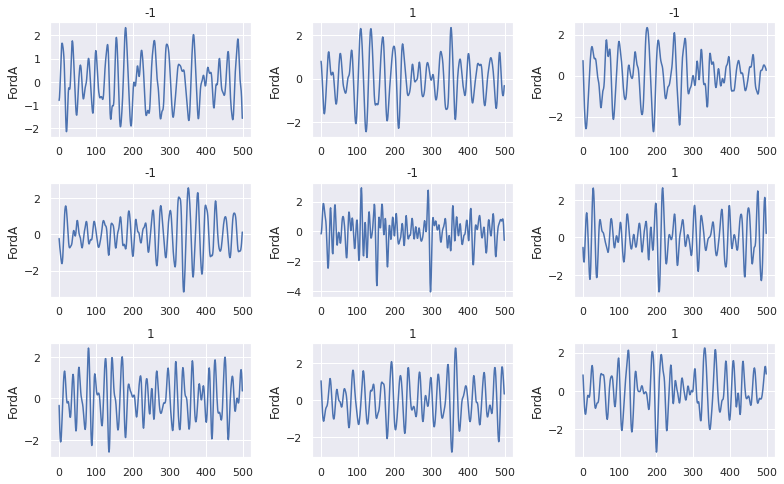

In [114]:
fig, ax = plt.subplots(nrows=3, ncols = 3, figsize=(13,8))
fig.subplots_adjust(hspace = 0.4, wspace = 0.3)
k = 0
for i in range(3):
    for j in range(3):
        ax[i, j].set_title(str(y_array_train[k]))
        sns.lineplot(data = df_train.loc[df_train['ID'] == k], x=df_train.loc[df_train['ID'] == k].index, y='FordA', ax = ax[i, j], estimator = None)
        k+=1

## Extract Features

In [8]:
%%time

df_features_train = extract_features(df_train, column_id = 'ID')

df_features_train['y'] = y_array_train

Feature Extraction: 100%|██████████| 60/60 [23:03<00:00, 23.06s/it]  


CPU times: user 9.29 s, sys: 3 s, total: 12.3 s
Wall time: 23min 9s


In [9]:
%%time

df_features_test = extract_features(df_test, column_id = 'ID')

df_features_test['y'] = y_array_test

Feature Extraction: 100%|██████████| 60/60 [08:33<00:00,  8.55s/it] 


CPU times: user 3.48 s, sys: 1.14 s, total: 4.62 s
Wall time: 8min 35s


In [5]:
df_features_test.head()

,FordA__variance_larger_than_standard_deviation,FordA__has_duplicate_max,FordA__has_duplicate_min,FordA__has_duplicate,FordA__sum_values,FordA__abs_energy,FordA__mean_abs_change,FordA__mean_change,FordA__mean_second_derivative_central,FordA__median,...,FordA__fourier_entropy__bins_3,FordA__fourier_entropy__bins_5,FordA__fourier_entropy__bins_10,FordA__fourier_entropy__bins_100,FordA__permutation_entropy__dimension_3__tau_1,FordA__permutation_entropy__dimension_4__tau_1,FordA__permutation_entropy__dimension_5__tau_1,FordA__permutation_entropy__dimension_6__tau_1,FordA__permutation_entropy__dimension_7__tau_1,y
0,0.0,0.0,0.0,1.0,2.783100e-07,499.000002,0.335096,-0.001310,-0.000130,-0.001575,...,0.243347,0.357079,0.663578,1.060959,1.251536,1.830930,2.427212,3.005851,3.592681,-1
1,0.0,0.0,0.0,1.0,6.134000e-07,499.000000,0.332784,-0.003426,-0.000205,0.039186,...,0.396337,0.646135,0.822578,1.236181,1.276580,1.867451,2.475124,3.127001,3.777374,-1
2,0.0,0.0,0.0,1.0,-1.045000e-07,498.999998,0.166634,-0.010133,-0.000232,0.015263,...,0.155665,0.215617,0.215617,0.316475,1.044081,1.390429,1.735894,2.097904,2.460418,-1
3,0.0,0.0,0.0,0.0,1.563000e-07,499.000001,0.219136,-0.004492,-0.000158,-0.016963,...,0.125256,0.170467,0.333204,0.737582,1.114963,1.559045,2.014253,2.490957,2.963024,1
4,0.0,0.0,0.0,1.0,-3.645000e-07,499.000002,0.212297,0.002697,0.000100,0.046735,...,0.183378,0.183378,0.245901,0.788016,1.148104,1.609043,2.101077,2.624707,3.148484,-1


## Build model

In [50]:
df_features_train = pd.read_csv('df_features_train.csv')
df_features_test = pd.read_csv('df_features_test.csv')

In [5]:
df_features_train.shape, df_features_test.shape

((3601, 780), (1320, 780))

In [29]:
model = RandomForestClassifier(random_state = 1)
model.fit(df_features_train.drop('y', axis = 1), df_features_train['y'])

metrics.accuracy_score(df_features_test['y'], model.predict(df_features_test.drop('y', axis = 1)))

1.0

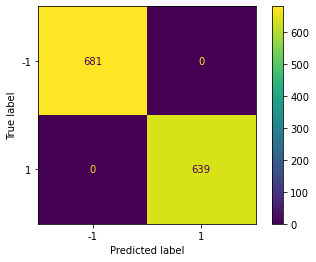

In [30]:
plot_confusion_matrix(model, df_features_test.drop('y', axis = 1), df_features_test['y'])

## Features reduction I

In [ ]:
df_train_relevant_features = extract_relevant_features(df_train, y = pd.Series(y_array_train), column_id = 'ID')
df_test_relevant_features = extract_relevant_features(df_train, y =  pd.Series(y_array_test), column_id = 'ID')


df_train_relevant_features['y'] = y_array_train
df_test_relevant_features['y'] = y_array_test

In [89]:
df_train_relevant_features.head()

,FordA__has_duplicate,FordA__ratio_value_number_to_time_series_length,FordA__percentage_of_reoccurring_datapoints_to_all_datapoints,FordA__percentage_of_reoccurring_values_to_all_values,"FordA__fft_aggregated__aggtype_""centroid""",FordA__ar_coefficient__coeff_1__k_10,FordA__autocorrelation__lag_6,FordA__autocorrelation__lag_7,FordA__cid_ce__normalize_True,FordA__autocorrelation__lag_1,...,FordA__ar_coefficient__coeff_10__k_10,"FordA__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0",FordA__number_peaks__n_10,FordA__standard_deviation,FordA__variance,FordA__variance_larger_than_standard_deviation,"FordA__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""",FordA__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"FordA__fft_coefficient__attr_""abs""__coeff_15",y
0.0,0.0,1.00,0.00,0.000000,15.644616,-0.906498,-0.308107,0.264319,12.070807,-0.484732,...,0.019887,1.118823,1.0,1.029753,1.060391,1.0,1.390859,0.076473,9.609878,-1
1.0,0.0,1.00,0.00,0.000000,17.354246,-1.613684,0.445290,-0.394450,12.619685,-0.612608,...,-0.302873,1.127615,1.0,0.973317,0.947347,0.0,1.448379,0.070368,10.330352,1
2.0,1.0,0.96,0.08,0.041667,15.100470,-0.548948,-0.396834,0.600766,11.526159,-0.341740,...,-0.030336,1.137097,2.0,0.997853,0.995711,0.0,1.645466,0.058931,4.484947,-1
3.0,1.0,0.98,0.04,0.020408,17.414458,-1.104021,-0.635270,0.344084,13.207441,-0.769244,...,0.007574,0.680391,2.0,1.008724,1.017524,1.0,0.345313,0.304929,5.321747,-1
4.0,0.0,1.00,0.00,0.000000,13.390610,-0.097967,-0.030348,-0.075340,10.704302,-0.153933,...,-0.093309,1.042149,2.0,1.100838,1.211843,1.0,1.340968,0.171023,2.992489,-1


In [46]:
model = RandomForestClassifier(random_state = 1)
model.fit(df_train_relevant_features.drop('y', axis = 1), df_train_relevant_features['y'])

metrics.accuracy_score(df_test_relevant_features['y'], model.predict(df_test_relevant_features.drop('y', axis = 1)))

1.0

## Features reduction II

In [37]:
fi = pd.Series(dict(zip(df_features_test.drop('y', axis = 1).columns, list(model.feature_importances_))))
fi.loc[fi>0.01]

FordA__has_duplicate                                              0.057608
FordA__percentage_of_reoccurring_values_to_all_values             0.115883
FordA__percentage_of_reoccurring_datapoints_to_all_datapoints     0.123759
FordA__sum_of_reoccurring_values                                  0.024398
FordA__sum_of_reoccurring_data_points                             0.026165
FordA__ratio_value_number_to_time_series_length                   0.064155
FordA__autocorrelation__lag_8                                     0.013522
FordA__autocorrelation__lag_9                                     0.011599
FordA__agg_autocorrelation__f_agg_"var"__maxlag_40                0.012680
FordA__ar_coefficient__coeff_1__k_10                              0.079999
FordA__ar_coefficient__coeff_2__k_10                              0.060026
FordA__ar_coefficient__coeff_3__k_10                              0.019741
FordA__ar_coefficient__coeff_10__k_10                             0.011455
FordA__augmented_dickey_f

In [41]:
df_features_train_fi = df_features_train.drop(fi.loc[fi<=0.01].index, axis = 1)
df_features_test_fi = df_features_test.drop(fi.loc[fi<=0.01].index, axis = 1)

In [44]:
len(df_features_train_fi.columns), len(df_features_test_fi.columns)

(19, 19)

In [45]:
model = RandomForestClassifier(random_state = 1)
model.fit(df_features_train_fi.drop('y', axis = 1), df_features_train_fi['y'])

metrics.accuracy_score(df_features_test_fi['y'], model.predict(df_features_test_fi.drop('y', axis = 1)))

1.0

Feature Extraction: 100%|██████████| 60/60 [00:35<00:00,  1.69it/s]


## Features reduction III

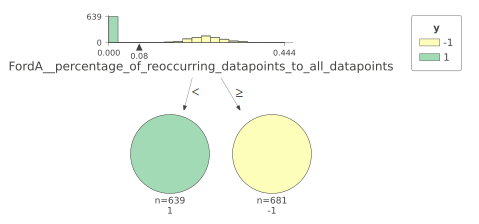

In [64]:
draw_tree_classification(df_features_test.drop('y', axis = 1), df_features_test['y'], max_depth=2, target_name = None, class_names=None, scale = 1.0)

bad vehicle for example:

In [74]:
df_train.loc[df_train['ID'] == 0]['FordA'].is_unique

False

good vehicle for example:

In [76]:
df_train.loc[df_train['ID'] == 1]['FordA'].is_unique

True